## Importing Packages

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow version and Keras version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.2


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


## Mount Google Drive to Colab environment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Research Assignment Reporting Functions

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

## Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [ ]:
# Get training and testing data from MNIST dataset
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [ ]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


## Review labels for training set

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



## Find frequency of each label in training and test sets

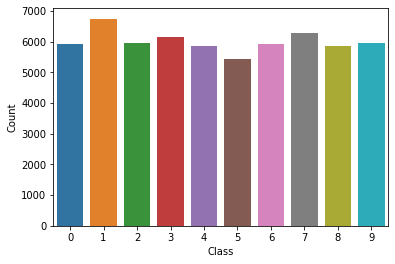

In [ ]:
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count); # using a seaborn bar plot

In [ ]:
# Y train Distrubtion Desc order
Counter(y_train).most_common() # returns a list of top 'n' elements from most common to least common

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [ ]:
# Y test Distrubtion Desc order
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

## Plot sample images with their labels

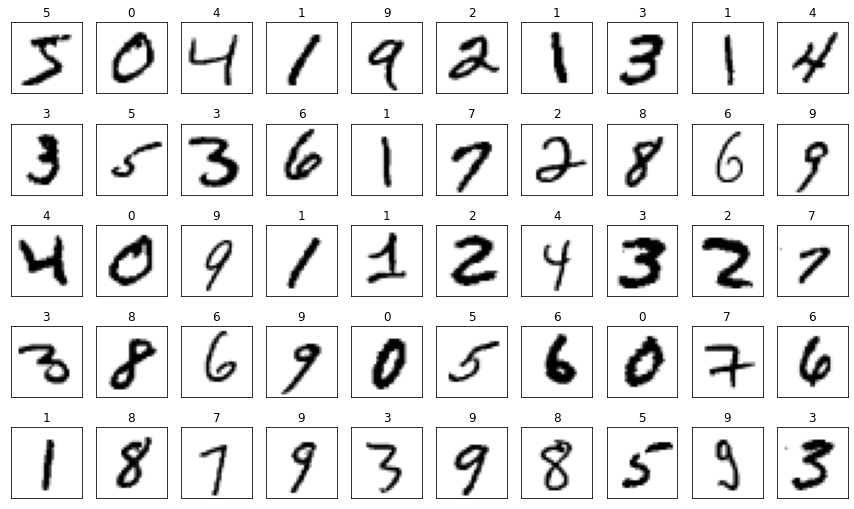

In [ ]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i) # 5 rows, 10 columns
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

##  Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [ ]:
y_train_encoded = to_categorical(y_train) # to_catergorical makes the the one-hot encoding
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


## Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [ ]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [ ]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [ ]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

## Review unique values with set from 1st image

In [ ]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


## Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [ ]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [ ]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}


## Creating the DNN Model

* In this step, we first choose the network architecture for the model. Then we build.compile, train and evaulate the model.

## Specify the network architecture

Below is the neural network architecture we will use today for classifying MNIST digits.

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/DNN_architecture.png?raw=1">

## Experiment 1

EXPERIMENT 1: Our dense neural network will consist of 784 input nodes, a hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits). We use mnist.load_data() to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 activation values of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a boxplot. We expect the overlap between the range of values in the "boxes" to be minimal. In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on CNN models in Assignment 2.

## Model 1

In [ ]:
#  Create the model

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # 784 input nodes
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax) # hidden layer with 1 node and 10 output nodes
])

In [ ]:
model.summary()

#shows layer type, output shape, number of parameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


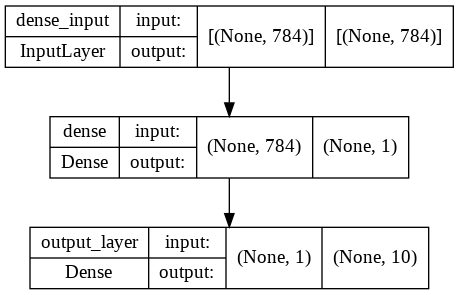

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model.fit(
    x_train_norm # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 200
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 8s 4ms/step - loss: 2.0258 - accuracy: 0.2082 - val_loss: 1.8972 - val_accuracy: 0.2221
Epoch 2/200
1719/1719 [==============================] - 6s 4ms/step - loss: 1.8562 - accuracy: 0.2478 - val_loss: 1.8053 - val_accuracy: 0.2587
Epoch 3/200
1719/1719 [==============================] - 7s 4ms/step - loss: 1.7928 - accuracy: 0.2697 - val_loss: 1.7498 - val_accuracy: 0.2715
Epoch 4/200
1719/1719 [==============================] - 6s 3ms/step - loss: 1.7542 - accuracy: 0.2752 - val_loss: 1.7200 - val_accuracy: 0.2727
Epoch 5/200
1719/1719 [==============================] - 6s 3ms/step - loss: 1.7330 - accuracy: 0.2799 - val_loss: 1.7002 - val_accuracy: 0.2893
Epoch 6/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.7187 - accuracy: 0.2880 - val_loss: 1.6902 - val_accuracy: 0.3081
Epoch 7/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.7084 - accuracy: 0.2988 - val_loss: 1.6852 - val_ac

In [ ]:
# Evaluation
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 1ms/step - loss: 1.6665 - accuracy: 0.3083
Test acc: 0.308


In [ ]:
# Make Predictions
preds = model.predict(x_test_norm) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


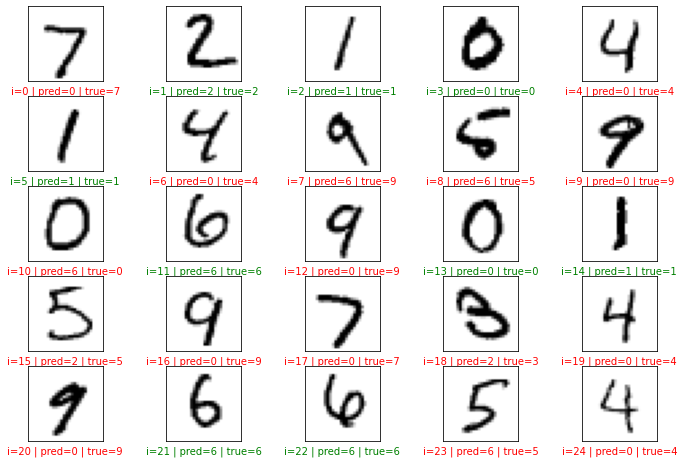

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
6   1.708     0.299     1.685         0.297
7   1.700     0.308     1.669         0.313
8   1.691     0.314     1.660         0.326
9   1.684     0.314     1.651         0.306
10  1.677     0.311     1.645         0.300

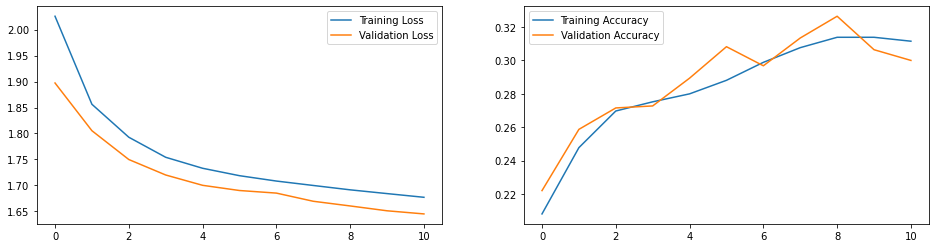

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.24      0.79      0.37       980
           1       0.63      0.96      0.76      1135
           2       0.23      0.45      0.30      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.28      0.08      0.13       892
           6       0.30      0.45      0.36       958
           7       0.13      0.09      0.10      1028
           8       0.23      0.16      0.19       974
           9       0.12      0.00      0.01      1009

    accuracy                           0.31     10000
   macro avg       0.22      0.30      0.22     10000
weighted avg       0.22      0.31      0.23     10000

Accuracy Score: 0.3083
Root Mean Square Error: 4.116819160468431


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

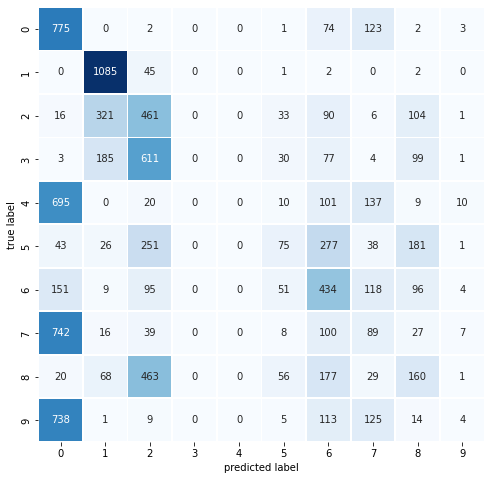

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
# cl_a, cl_b = 4, 9
# X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
# X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
# X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
# X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

# plt.figure(figsize=(16,8))

# # create subplots
# p1 = plt.subplot(221)
# p2 = plt.subplot(222)
# p3 = plt.subplot(223)
# p4 = plt.subplot(224)

# # plot the digits
# plot_digits(X_aa[:25], p1, images_per_row=5);
# plot_digits(X_ab[:25], p2, images_per_row=5);
# plot_digits(X_ba[:25], p3, images_per_row=5);
# plot_digits(X_bb[:25], p4, images_per_row=5);

# # subplot titles
# p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
# p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
# p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
# p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# # plt.savefig("error_analysis_digits_plot_EXP1_valid")

# plt.show()

### Analyzing the Activation Values of the Hidden Nodes

We want to examine the contribution of the individual hidden nodes to the classifications made by the model. We first get the activation values of all the hidden nodes for each of the 60,000 training images and treat these *128 activations* as the features that determine the classification class. For the sake of comparison,  we also consider the *784 pixels* of each training image and determine the contribution of the individual pixels to the predicted classification class.

Our goal is to use *box* and *scatter* plots to visualize how these features (*pixel* and *activation* values) correlate with the class labels. Because of the high dimension of the feature spaces, we apply *PCA decomposition* and *t-Distributed stochastic neighbor embedding* (`t-SNE`) to reduce the number of features in each case.

We use the following two articles as reference

 * https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
 * https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


1) Raw data is 60,000 X 784. Just do a scatter plot of col 1 vs col 2. Overlay the color coded classes. We  should not see any patterns since there is not much info in 2 cols to discriminate.

2) PCA of raw data – as we discussed earlier. Plot PC1 vs PC2 with overlay. This should be ‘better’ since these 2 capture the info from all 784 cols.

3) PCA of activation values – as we discussed earlier. This should be ‘better’ than the previous 2 since it has captured specific features of discrimination.

 ### Get the activation values of the hidden nodes

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 1)

In [ ]:
output_layer_activations.shape

(60000, 10)

In [ ]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 8.280742645263672


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.002 0.048 0.225 0.199 0.004 0.175 0.114 0.013 0.216 0.005]
The sum of the probabilities is (approximately) 1.0


 ### Create a dataframe with the activation values and the class labels

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0    1      2      3    4      5      6      7      8    9   \
actual_class  5.000  0.0  4.000  1.000  9.0  2.000  1.000  3.000  1.000  4.0   
act_val_0     2.323  0.0  0.677  4.913  0.0  1.661  5.775  2.544  5.446  0.0   

                 10     11     12     13     14  
actual_class  3.000  5.000  3.000  6.000  1.000  
act_val_0     3.233  3.324  4.448  1.103  5.929

 ### Visualize the activation values with boxplots

We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe.

<div class="alert alert-block alert-info">
    <b>seaborn.boxplot</b><br>
   ps://seaborn.pydata.org/generated/seaborn.boxplot.html
    </div>

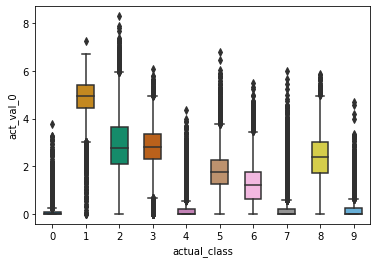

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

### Displaying The Range Of Activation Values For Each Class Labels

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

actual_class range_of_act_values
0             0         [0.0, 3.78]
1             1         [0.0, 7.23]
2             2         [0.0, 8.28]
3             3         [0.0, 6.07]
4             4         [0.0, 4.37]
5             5         [0.0, 6.77]
6             6          [0.0, 5.5]
7             7         [0.0, 5.99]
8             8         [0.0, 5.89]
9             9         [0.0, 4.69]

 ### Create a dataframe with the pixel values and class labels

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,128):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

0    1    2    3    4    5      6    7    8    9      10   11  \
actual_class  5.0  0.0  4.0  1.0  9.0  2.0  1.000  3.0  1.0  4.0  3.000  5.0   
pix_val_0     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_1     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_2     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_3     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
...           ...  ...  ...  ...  ...  ...    ...  ...  ...  ...    ...  ...   
pix_val_123   0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.165  0.0   
pix_val_124   0.0  0.0  0.0  0.0  0.0  0.0  0.569  0.0  0.0  0.0  0.463  0.0   
pix_val_125   0.0  0.0  0.0  0.0  0.0  0.0  1.000  0.0  0.0  0.0  0.859  0.0   
pix_val_126   0.0  0.0  0.0  0.0  0.0  0.0  0.827  0.0  0.0  0.0  0.651  0.0   
pix_val_127   0.0  0.2  0.0  0.0  0.0  0.0  0.122  0.0  0.0  0.0  0.463  0.0   

               12     13   14  
actual_class  3.0  6.000  1.0  
pix_val_0     0.0  0.000  0.0  
pix_val_1     0.0  0.000  0.0  
pix_val_2     0.0  0.000  0.0  
pix_val_3     0.0  0.000  0.0  
...           ...    ...  ...  
pix_val_123   0.0  0.000  0.0  
pix_val_124   0.0  0.000  0.0  
pix_val_125   0.0  0.090  0.0  
pix_val_126   0.0  0.773  0.0  
pix_val_127   0.0  0.992  0.0  

[129 rows x 15 columns]

In [ ]:
pixel_df.pix_val_77.value_counts()

0.000000    59720
1.000000       25
0.996078       13
0.992157        9
0.050980        6
            ...  
0.894118        1
0.690196        1
0.725490        1
0.517647        1
0.819608        1
Name: pix_val_77, Length: 150, dtype: int64

In [ ]:
pixel_df.pix_val_78.value_counts()

0.000000    59862
1.000000        6
0.960784        4
0.992157        4
0.141176        4
            ...  
0.556863        1
0.584314        1
0.427451        1
0.078431        1
0.501961        1
Name: pix_val_78, Length: 97, dtype: int64

### Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

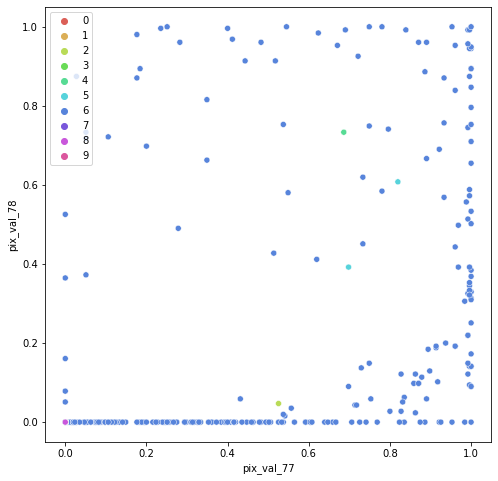

In [ ]:
plt.figure(figsize=(8, 8))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

# Experiment 2

EXPERIMENT 2: This time our dense neural network will have 784 input nodes, a hidden layer with 2 nodes and 10 output nodes (corresponding to the 10 digits). For each of the 60,000 images, the output of the two hidden nodes are plotted using a scatterplot. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in EXPERIMENT 1, the color clusters should have very little overlap. Also compare the accuracy % & confusion matrix of Experiments 1 & 2. Again, the goal is to get more insights.

## Model 2

In [ ]:
#  Create the model

model2 = Sequential()
model2.add(Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001))) # 784 input nodes
model2.add(Dense(units = 10, activation = tf.nn.softmax)) # 1st hidden layer with 1 node and 10 output nodes



In [ ]:
model2.summary()

#shows layer type, output shape, number of parameters

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 1570      
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


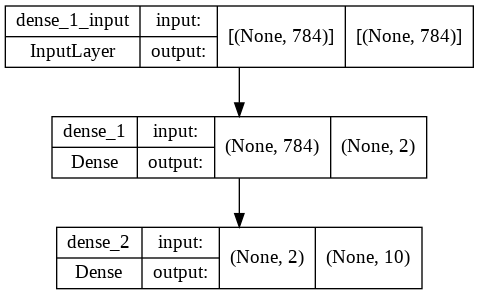

In [ ]:
keras.utils.plot_model(model2, "mnist_model.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model2.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model2.fit(
    x_train_norm # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 200
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model2.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6450 - accuracy: 0.3754 - val_loss: 1.3534 - val_accuracy: 0.5068
Epoch 2/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3386 - accuracy: 0.5080 - val_loss: 1.2252 - val_accuracy: 0.5568
Epoch 3/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.2680 - accuracy: 0.5491 - val_loss: 1.1701 - val_accuracy: 0.5844
Epoch 4/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.2224 - accuracy: 0.5773 - val_loss: 1.1277 - val_accuracy: 0.6070
Epoch 5/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.1856 - accuracy: 0.5935 - val_loss: 1.0886 - val_accuracy: 0.6339
Epoch 6/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.1603 - accuracy: 0.6066 - val_loss: 1.0701 - val_accuracy: 0.6417
Epoch 7/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.1423 - accuracy: 0.6149 - val_loss: 1.0528 - val_ac

In [ ]:
# Evaluation
model2 = tf.keras.models.load_model("DNN_model2.h5")
print(f"Test acc: {model2.evaluate(x_test_norm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 1ms/step - loss: 1.0831 - accuracy: 0.6495
Test acc: 0.650


In [ ]:
# Make Predictions
preds = model2.predict(x_test_norm) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


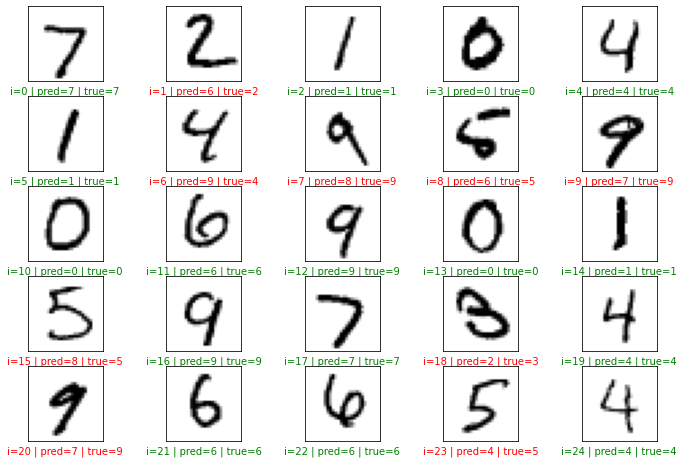

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
8   1.117     0.629     1.027         0.664
9   1.108     0.633     1.019         0.661
10  1.099     0.637     1.009         0.673
11  1.092     0.642     1.011         0.667
12  1.086     0.644     1.026         0.656

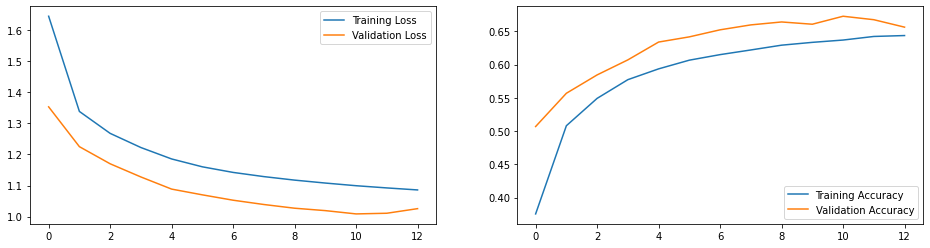

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred2= model2.predict(x_test_norm)
pred2=np.argmax(pred2, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred2)

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       980
           1       0.79      0.95      0.86      1135
           2       0.62      0.53      0.57      1032
           3       0.60      0.72      0.65      1010
           4       0.57      0.62      0.59       982
           5       0.40      0.34      0.36       892
           6       0.84      0.87      0.85       958
           7       0.67      0.74      0.70      1028
           8       0.48      0.37      0.41       974
           9       0.56      0.43      0.48      1009

    accuracy                           0.65     10000
   macro avg       0.63      0.64      0.63     10000
weighted avg       0.64      0.65      0.64     10000

Accuracy Score: 0.6495
Root Mean Square Error: 2.334309319691801


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model2.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

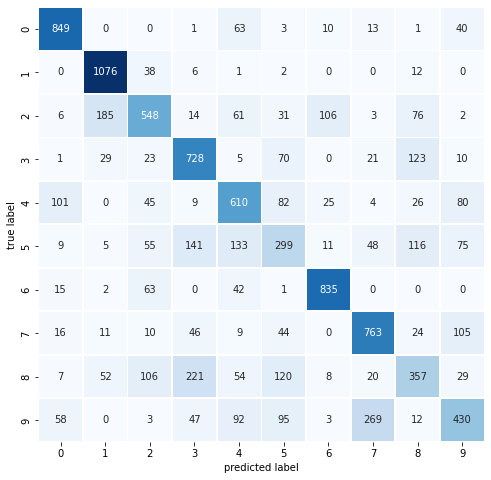

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

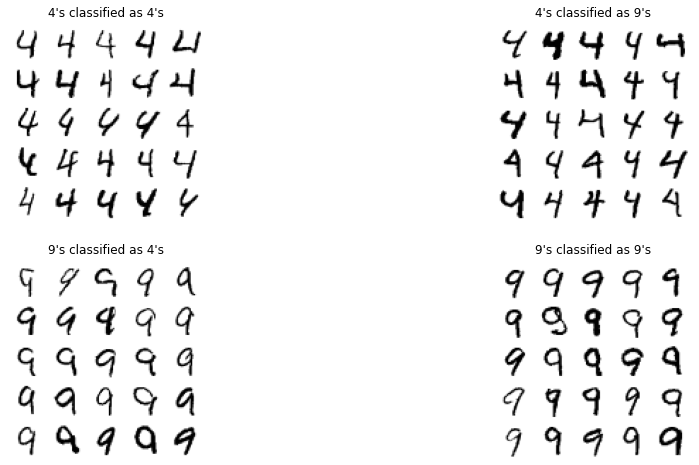

In [ ]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

plt.figure(figsize=(16,8))

# create subplots
p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

# plot the digits
plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);

# subplot titles
p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

## Analyzing the Activation Values of the Hidden Nodes

We want to examine the contribution of the individual hidden nodes to the classifications made by the model. We first get the activation values of all the hidden nodes for each of the 60,000 training images and treat these *128 activations* as the features that determine the classification class. For the sake of comparison,  we also consider the *784 pixels* of each training image and determine the contribution of the individual pixels to the predicted classification class.

Our goal is to use *box* and *scatter* plots to visualize how these features (*pixel* and *activation* values) correlate with the class labels. Because of the high dimension of the feature spaces, we apply *PCA decomposition* and *t-Distributed stochastic neighbor embedding* (`t-SNE`) to reduce the number of features in each case.

We use the following two articles as reference

 * https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
 * https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


1) Raw data is 60,000 X 784. Just do a scatter plot of col 1 vs col 2. Overlay the color coded classes. We  should not see any patterns since there is not much info in 2 cols to discriminate.

2) PCA of raw data – as we discussed earlier. Plot PC1 vs PC2 with overlay. This should be ‘better’ since these 2 capture the info from all 784 cols.

3) PCA of activation values – as we discussed earlier. This should be ‘better’ than the previous 2 since it has captured specific features of discrimination.

 ## Get the activation values of the hidden nodes

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 2)

In [ ]:
output_layer_activations.shape

(60000, 10)

In [ ]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 15.500266075134277


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.    0.    0.004 0.268 0.025 0.291 0.    0.067 0.22  0.126]
The sum of the probabilities is (approximately) 1.0


 ## Create a dataframe with the activation values and the class labels

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,2):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0      1      2      3      4      5      6      7      8   \
actual_class  5.000  0.000  4.000  1.000  9.000  2.000  1.000  3.000  1.000   
act_val_0     4.223  0.000  3.052  4.369  2.537  1.847  6.065  5.355  4.986   
act_val_1     3.706  5.193  2.532  0.000  5.192  1.532  0.000  3.382  0.000   

                 9      10     11     12   13     14  
actual_class  4.000  3.000  5.000  3.000  6.0  1.000  
act_val_0     1.154  6.855  3.665  7.970  0.0  5.326  
act_val_1     2.076  4.228  1.060  3.395  0.0  0.000

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,2):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0      1      2      3      4      5      6      7      8   \
actual_class  5.000  0.000  4.000  1.000  9.000  2.000  1.000  3.000  1.000   
act_val_0     4.223  0.000  3.052  4.369  2.537  1.847  6.065  5.355  4.986   
act_val_1     3.706  5.193  2.532  0.000  5.192  1.532  0.000  3.382  0.000   

                 9      10     11     12   13     14  
actual_class  4.000  3.000  5.000  3.000  6.0  1.000  
act_val_0     1.154  6.855  3.665  7.970  0.0  5.326  
act_val_1     2.076  4.228  1.060  3.395  0.0  0.000

 ## Visualize the activation values with boxplots

We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe.

<div class="alert alert-block alert-info">
    <b>seaborn.boxplot</b><br>
   ps://seaborn.pydata.org/generated/seaborn.boxplot.html
    </div>

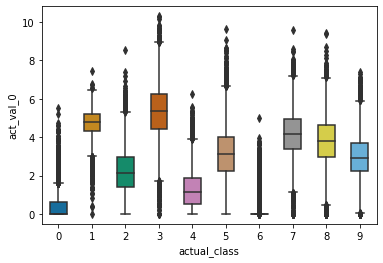

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

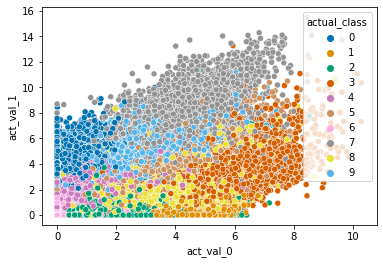

In [ ]:
splot = sns.scatterplot(y='act_val_1', x='act_val_0',
                 data=activation_df, hue = 'actual_class',
                 palette="colorblind")

## Displaying The Range Of Activation Values For Each Class Labels

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

actual_class range_of_act_values
0             0         [0.0, 5.53]
1             1         [0.0, 7.44]
2             2         [0.0, 8.53]
3             3        [0.0, 10.29]
4             4         [0.0, 6.26]
5             5         [0.0, 9.63]
6             6          [0.0, 5.0]
7             7         [0.0, 9.56]
8             8         [0.0, 9.43]
9             9         [0.0, 7.41]

 ## Create a dataframe with the pixel values and class labels

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,128):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

0    1    2    3    4    5      6    7    8    9      10   11  \
actual_class  5.0  0.0  4.0  1.0  9.0  2.0  1.000  3.0  1.0  4.0  3.000  5.0   
pix_val_0     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_1     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_2     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_3     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
...           ...  ...  ...  ...  ...  ...    ...  ...  ...  ...    ...  ...   
pix_val_123   0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.165  0.0   
pix_val_124   0.0  0.0  0.0  0.0  0.0  0.0  0.569  0.0  0.0  0.0  0.463  0.0   
pix_val_125   0.0  0.0  0.0  0.0  0.0  0.0  1.000  0.0  0.0  0.0  0.859  0.0   
pix_val_126   0.0  0.0  0.0  0.0  0.0  0.0  0.827  0.0  0.0  0.0  0.651  0.0   
pix_val_127   0.0  0.2  0.0  0.0  0.0  0.0  0.122  0.0  0.0  0.0  0.463  0.0   

               12     13   14  
actual_class  3.0  6.000  1.0  
pix_val_0     0.0  0.000  0.0  
pix_val_1     0.0  0.000  0.0  
pix_val_2     0.0  0.000  0.0  
pix_val_3     0.0  0.000  0.0  
...           ...    ...  ...  
pix_val_123   0.0  0.000  0.0  
pix_val_124   0.0  0.000  0.0  
pix_val_125   0.0  0.090  0.0  
pix_val_126   0.0  0.773  0.0  
pix_val_127   0.0  0.992  0.0  

[129 rows x 15 columns]

In [ ]:
pixel_df.pix_val_77.value_counts()

0.000000    59720
1.000000       25
0.996078       13
0.992157        9
0.050980        6
            ...  
0.894118        1
0.690196        1
0.725490        1
0.517647        1
0.819608        1
Name: pix_val_77, Length: 150, dtype: int64

In [ ]:
pixel_df.pix_val_78.value_counts()

0.000000    59862
1.000000        6
0.960784        4
0.992157        4
0.141176        4
            ...  
0.556863        1
0.584314        1
0.427451        1
0.078431        1
0.501961        1
Name: pix_val_78, Length: 97, dtype: int64

### Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

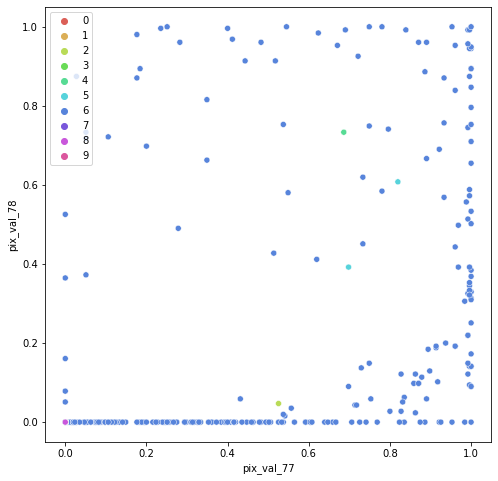

In [ ]:
plt.figure(figsize=(8, 8))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

# Experiment 3

You can explore with more hidden nodes. At least 5 more variations of this architecture NEEDS to be tried. Then you end up with 1 ‘final’ model. Say the ‘best’ model.

## Model 3

Model 3 will be built using 784 input nodes, a hiden layer with 1 node and 10 putput nodes. The difference between this model and model 1 is that model 3 will use sigmoid and not softmax.



In [ ]:
#  Create the model

model3 = Sequential()
model3.add(Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001))) # 1 nodes
model3.add(Dense(units = 10, activation = tf.nn.sigmoid)) # using sigmoid and not softmax


In [ ]:
model3.summary()

#shows layer type, output shape, number of parameters

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 785       
                                                                 
 dense_4 (Dense)             (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


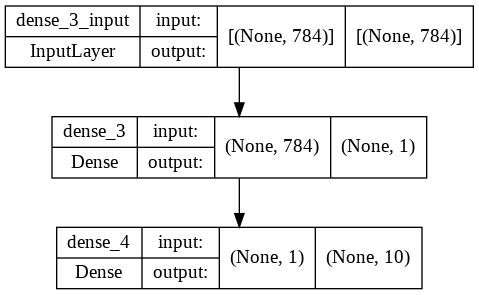

In [ ]:
keras.utils.plot_model(model3, "mnist_model.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model3.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model3.fit(
    x_train_norm # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 200
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model3.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 1.9975 - accuracy: 0.2027 - val_loss: 1.8723 - val_accuracy: 0.2177
Epoch 2/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.8458 - accuracy: 0.2384 - val_loss: 1.7969 - val_accuracy: 0.2501
Epoch 3/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.7999 - accuracy: 0.2556 - val_loss: 1.7724 - val_accuracy: 0.2545
Epoch 4/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.7787 - accuracy: 0.2636 - val_loss: 1.7544 - val_accuracy: 0.2773
Epoch 5/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.7651 - accuracy: 0.2715 - val_loss: 1.7388 - val_accuracy: 0.2841
Epoch 6/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.7552 - accuracy: 0.2773 - val_loss: 1.7261 - val_accuracy: 0.2845
Epoch 7/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.7466 - accuracy: 0.2863 - val_loss: 1.7161 - val_ac

In [ ]:
# Evaluation
model3 = tf.keras.models.load_model("DNN_model3.h5")
print(f"Test acc: {model3.evaluate(x_test_norm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 2ms/step - loss: 1.7759 - accuracy: 0.3254
Test acc: 0.325


In [ ]:
# Make Predictions
preds = model3.predict(x_test_norm) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


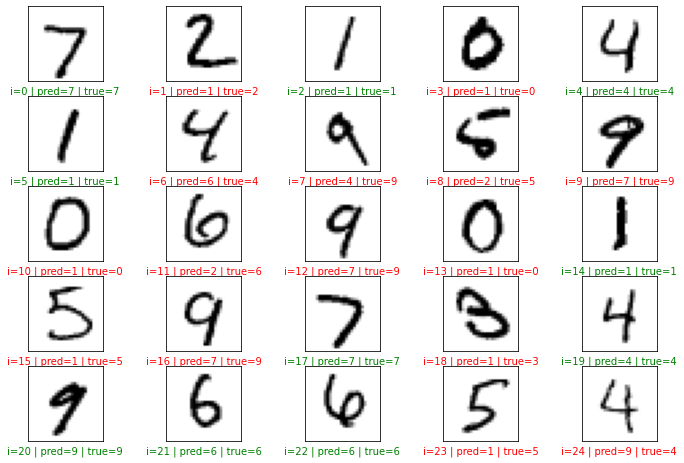

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
10  1.718     0.319     1.680         0.340
11  1.713     0.325     1.677         0.341
12  1.710     0.325     1.673         0.341
13  1.706     0.329     1.668         0.331
14  1.703     0.330     1.666         0.330

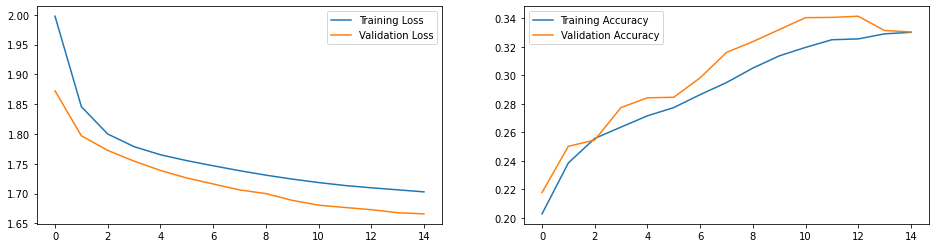

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred3= model3.predict(x_test_norm)
pred3=np.argmax(pred3, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred3)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.22      0.94      0.35      1135
           2       0.28      0.28      0.28      1032
           3       0.00      0.00      0.00      1010
           4       0.46      0.26      0.34       982
           5       0.00      0.00      0.00       892
           6       0.39      0.47      0.43       958
           7       0.63      0.71      0.67      1028
           8       0.00      0.00      0.00       974
           9       0.37      0.45      0.41      1009

    accuracy                           0.33     10000
   macro avg       0.24      0.31      0.25     10000
weighted avg       0.24      0.33      0.25     10000

Accuracy Score: 0.3254
Root Mean Square Error: 3.0572700240574107


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model3.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

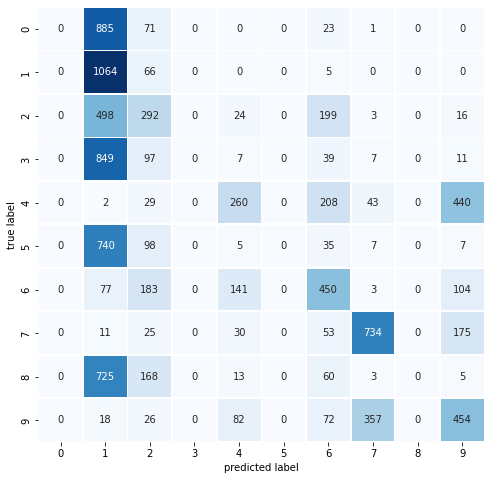

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
# cl_a, cl_b = 4, 9
# X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
# X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
# X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
# X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

# plt.figure(figsize=(16,8))

# # create subplots
# p1 = plt.subplot(221)
# p2 = plt.subplot(222)
# p3 = plt.subplot(223)
# p4 = plt.subplot(224)

# # plot the digits
# plot_digits(X_aa[:25], p1, images_per_row=5);
# plot_digits(X_ab[:25], p2, images_per_row=5);
# plot_digits(X_ba[:25], p3, images_per_row=5);
# plot_digits(X_bb[:25], p4, images_per_row=5);

# # subplot titles
# p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
# p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
# p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
# p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# # plt.savefig("error_analysis_digits_plot_EXP1_valid")

# plt.show()

## Model 4

Model 4 will be built using 4 input nodes, a hiden layer with 4 node and 10 output nodes. The difference between this model and model 1 is that model 4 will use 4 nodes instead of 1.

In [ ]:
#  Create the model

model4 = Sequential()
model4.add(Dense(input_shape=[784], units=4, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001))) # 4 nodes
model4.add(Dense(units = 10, activation = tf.nn.softmax))


In [ ]:
model4.summary()

#shows layer type, output shape, number of parameters

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 3140      
                                                                 
 dense_6 (Dense)             (None, 10)                50        
                                                                 
Total params: 3,190
Trainable params: 3,190
Non-trainable params: 0
_________________________________________________________________


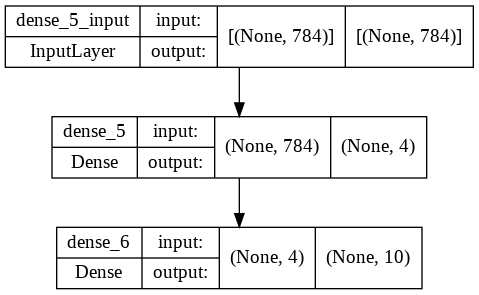

In [ ]:
keras.utils.plot_model(model4, "mnist_model.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model4.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model4.fit(
    x_train_norm # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 200
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model4.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0440 - accuracy: 0.6891 - val_loss: 0.6330 - val_accuracy: 0.8299
Epoch 2/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6831 - accuracy: 0.8160 - val_loss: 0.5532 - val_accuracy: 0.8521
Epoch 3/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6296 - accuracy: 0.8312 - val_loss: 0.5310 - val_accuracy: 0.8593
Epoch 4/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6031 - accuracy: 0.8362 - val_loss: 0.5125 - val_accuracy: 0.8665
Epoch 5/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5867 - accuracy: 0.8406 - val_loss: 0.4910 - val_accuracy: 0.8709
Epoch 6/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5741 - accuracy: 0.8436 - val_loss: 0.4834 - val_accuracy: 0.8739
Epoch 7/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5655 - accuracy: 0.8459 - val_loss: 0.4717 - val_ac

In [ ]:
# Evaluation
model4 = tf.keras.models.load_model("DNN_model4.h5")
print(f"Test acc: {model4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 1ms/step - loss: 0.5275 - accuracy: 0.8567
Test acc: 0.857


In [ ]:
# Make Predictions
preds = model4.predict(x_test_norm) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


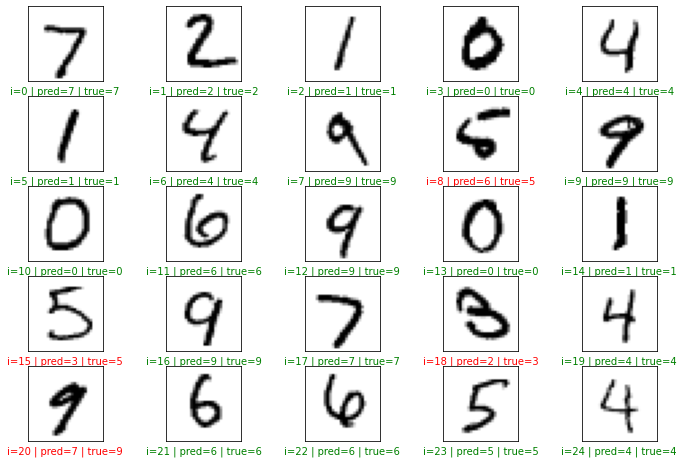

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
9   0.547     0.849     0.458         0.881
10  0.543     0.851     0.460         0.878
11  0.539     0.852     0.448         0.884
12  0.536     0.853     0.451         0.880
13  0.533     0.854     0.452         0.879

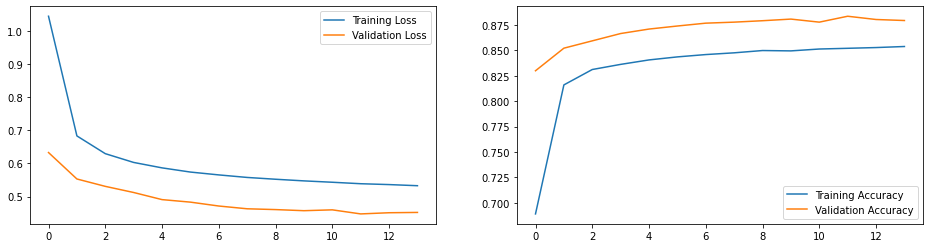

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred4= model4.predict(x_test_norm)
pred4=np.argmax(pred4, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred4)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       980
           1       0.94      0.97      0.95      1135
           2       0.86      0.80      0.83      1032
           3       0.86      0.83      0.85      1010
           4       0.83      0.91      0.87       982
           5       0.78      0.76      0.77       892
           6       0.89      0.90      0.90       958
           7       0.85      0.87      0.86      1028
           8       0.77      0.72      0.75       974
           9       0.86      0.83      0.85      1009

    accuracy                           0.86     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy Score: 0.8567
Root Mean Square Error: 1.5407790237409127


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model4.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

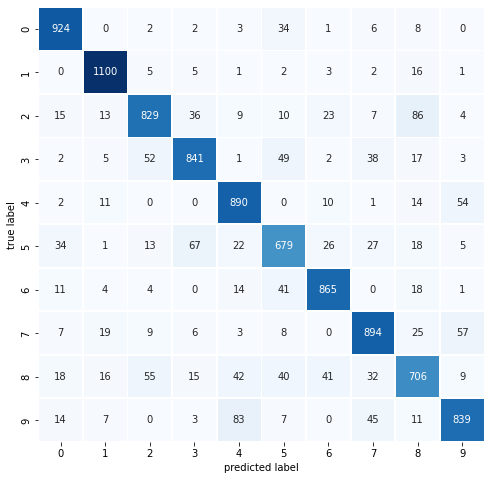

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

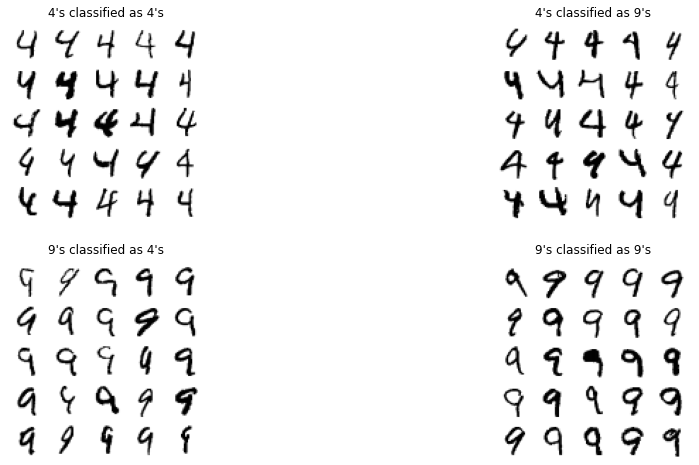

In [ ]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

plt.figure(figsize=(16,8))

# create subplots
p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

# plot the digits
plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);

# subplot titles
p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

## Model 5

Model 5 will be built using 784 input nodes, a hiden layer with 8 node and 10 output nodes. The difference between this model and model 1 is that model 5 will use 8 nodes instead of 1.

In [ ]:
#  Create the model

model5 = Sequential([
    Dense(input_shape=[784], units=8, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # 8 input nodes
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax) # hidden layer with 1 node and 10 output nodes
])

In [ ]:
model5.summary()

#shows layer type, output shape, number of parameters

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 6280      
                                                                 
 output_layer (Dense)        (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


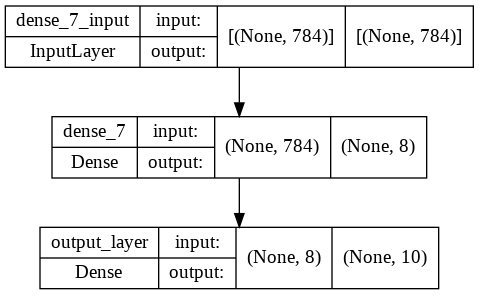

In [ ]:
keras.utils.plot_model(model5, "mnist_model.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model5.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model5.fit(
    x_train_norm # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 200
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model5.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7088 - accuracy: 0.8063 - val_loss: 0.3850 - val_accuracy: 0.9098
Epoch 2/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4387 - accuracy: 0.8901 - val_loss: 0.3345 - val_accuracy: 0.9218
Epoch 3/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3909 - accuracy: 0.9019 - val_loss: 0.3137 - val_accuracy: 0.9272
Epoch 4/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3688 - accuracy: 0.9079 - val_loss: 0.2984 - val_accuracy: 0.9288
Epoch 5/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3553 - accuracy: 0.9111 - val_loss: 0.2837 - val_accuracy: 0.9318
Epoch 6/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3470 - accuracy: 0.9131 - val_loss: 0.2758 - val_accuracy: 0.9348
Epoch 7/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3399 - accuracy: 0.9138 - val_loss: 0.2771 - val_ac

In [ ]:
# Evaluation
model5 = tf.keras.models.load_model("DNN_model5.h5")
print(f"Test acc: {model5.evaluate(x_test_norm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 2ms/step - loss: 0.3206 - accuracy: 0.9197
Test acc: 0.920


In [ ]:
# Make Predictions
preds = model5.predict(x_test_norm) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


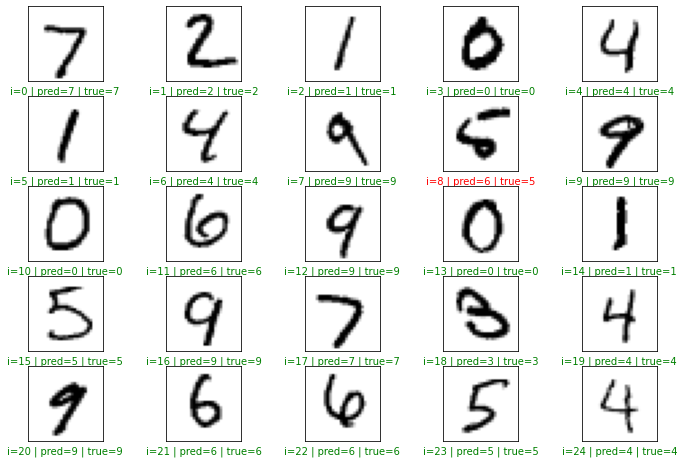

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
5  0.347     0.913     0.276         0.935
6  0.340     0.914     0.277         0.935
7  0.335     0.914     0.267         0.935
8  0.330     0.916     0.270         0.935
9  0.325     0.917     0.268         0.934

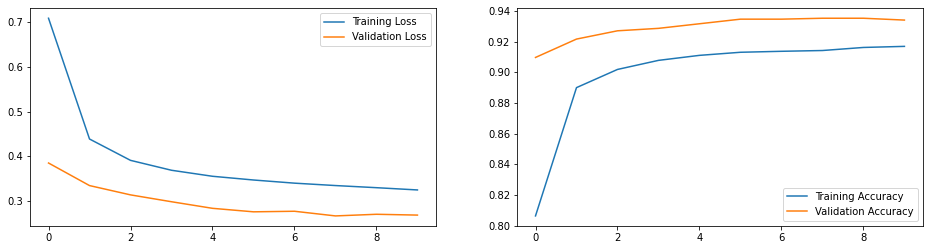

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred5= model5.predict(x_test_norm)
pred5=np.argmax(pred5, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred5)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.92      0.90      0.91      1010
           4       0.90      0.93      0.92       982
           5       0.89      0.86      0.88       892
           6       0.93      0.95      0.94       958
           7       0.94      0.92      0.93      1028
           8       0.86      0.90      0.88       974
           9       0.92      0.89      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9197
Root Mean Square Error: 1.2139192724394814


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

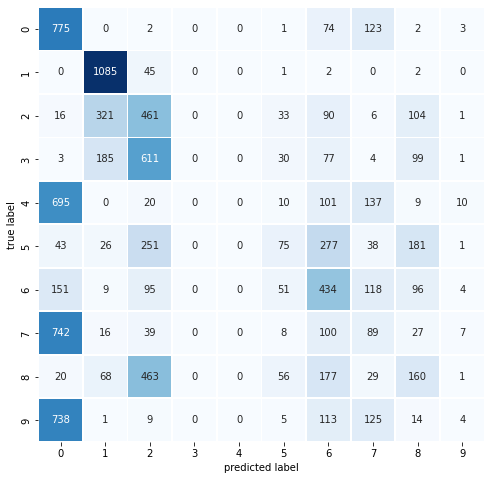

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
# cl_a, cl_b = 4, 9
# X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
# X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
# X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
# X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

# plt.figure(figsize=(16,8))

# # create subplots
# p1 = plt.subplot(221)
# p2 = plt.subplot(222)
# p3 = plt.subplot(223)
# p4 = plt.subplot(224)

# # plot the digits
# plot_digits(X_aa[:25], p1, images_per_row=5);
# plot_digits(X_ab[:25], p2, images_per_row=5);
# plot_digits(X_ba[:25], p3, images_per_row=5);
# plot_digits(X_bb[:25], p4, images_per_row=5);

# # subplot titles
# p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
# p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
# p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
# p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# # plt.savefig("error_analysis_digits_plot_EXP1_valid")

# plt.show()

## Model 6

Model 6 will be built using 4 nodes and 500 epochs

In [ ]:
#  Create the model

model6 = Sequential([
    Dense(input_shape=[784], units=4, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # 4 nodes
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax) # hidden layer with 1 node and 10 output nodes
])

In [ ]:
model6.summary()

#shows layer type, output shape, number of parameters

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4)                 3140      
                                                                 
 output_layer (Dense)        (None, 10)                50        
                                                                 
Total params: 3,190
Trainable params: 3,190
Non-trainable params: 0
_________________________________________________________________


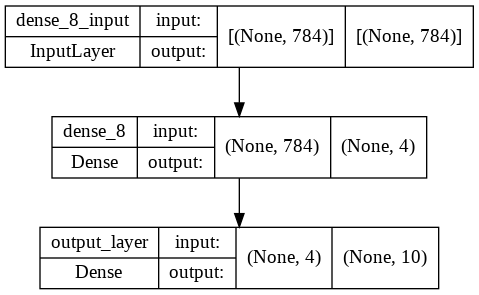

In [ ]:
keras.utils.plot_model(model6, "mnist_model.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model6.compile(optimizer='sgd',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model6.fit(
    x_train_norm # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 500 # changed from 200 to 500
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model6.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/500
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6468 - accuracy: 0.4627 - val_loss: 1.2297 - val_accuracy: 0.5988
Epoch 2/500
1719/1719 [==============================] - 3s 2ms/step - loss: 1.1392 - accuracy: 0.6293 - val_loss: 0.9607 - val_accuracy: 0.7023
Epoch 3/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.9340 - accuracy: 0.7052 - val_loss: 0.7918 - val_accuracy: 0.7611
Epoch 4/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8147 - accuracy: 0.7539 - val_loss: 0.6932 - val_accuracy: 0.8103
Epoch 5/500
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7352 - accuracy: 0.7886 - val_loss: 0.6243 - val_accuracy: 0.8305
Epoch 6/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6854 - accuracy: 0.8084 - val_loss: 0.5831 - val_accuracy: 0.8451
Epoch 7/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6555 - accuracy: 0.8182 - val_loss: 0.5602 - val_ac

In [ ]:
# Evaluation
model6 = tf.keras.models.load_model("DNN_model6.h5")
print(f"Test acc: {model6.evaluate(x_test_norm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 1ms/step - loss: 0.5537 - accuracy: 0.8530
Test acc: 0.853


In [ ]:
# Make Predictions
preds = model6.predict(x_test_norm) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


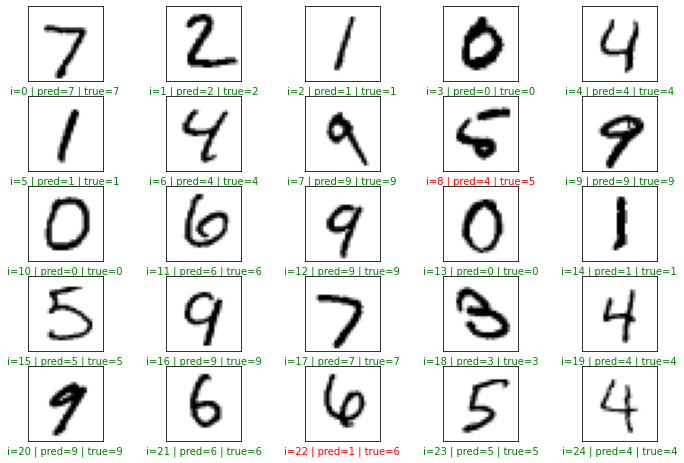

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
12  0.583     0.841     0.486         0.871
13  0.576     0.843     0.479         0.873
14  0.570     0.845     0.473         0.876
15  0.564     0.847     0.466         0.875
16  0.560     0.848     0.464         0.876

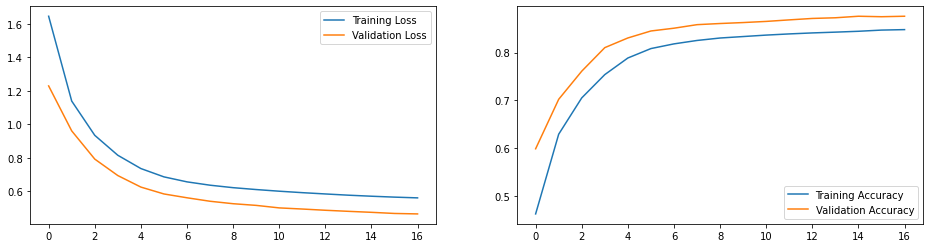

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred6= model6.predict(x_test_norm)
pred6=np.argmax(pred6, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred6)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       980
           1       0.90      0.96      0.93      1135
           2       0.89      0.84      0.87      1032
           3       0.84      0.84      0.84      1010
           4       0.87      0.87      0.87       982
           5       0.78      0.71      0.75       892
           6       0.89      0.91      0.90       958
           7       0.86      0.83      0.84      1028
           8       0.78      0.74      0.76       974
           9       0.83      0.86      0.84      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy Score: 0.853
Root Mean Square Error: 1.5


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

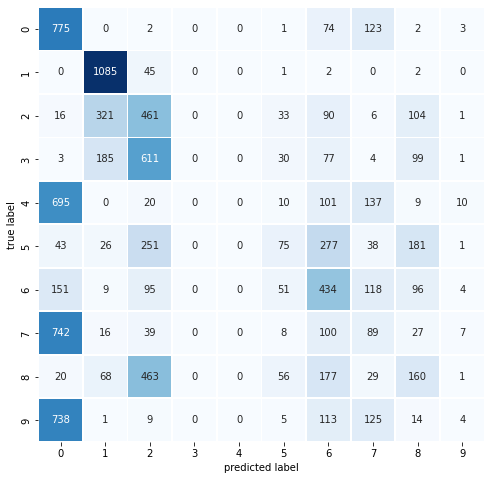

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
# cl_a, cl_b = 4, 9
# X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
# X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
# X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
# X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

# plt.figure(figsize=(16,8))

# # create subplots
# p1 = plt.subplot(221)
# p2 = plt.subplot(222)
# p3 = plt.subplot(223)
# p4 = plt.subplot(224)

# # plot the digits
# plot_digits(X_aa[:25], p1, images_per_row=5);
# plot_digits(X_ab[:25], p2, images_per_row=5);
# plot_digits(X_ba[:25], p3, images_per_row=5);
# plot_digits(X_bb[:25], p4, images_per_row=5);

# # subplot titles
# p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
# p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
# p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
# p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# # plt.savefig("error_analysis_digits_plot_EXP1_valid")

# plt.show()

## Model 7

**Model 7** will be built using using 8 nodes and 500 epochs

In [ ]:
#  Create the model

model7 = Sequential([
    Dense(input_shape=[784], units=8, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # 8 nodes
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])


In [ ]:
model7.summary()

#shows layer type, output shape, number of parameters

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8)                 6280      
                                                                 
 output_layer (Dense)        (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


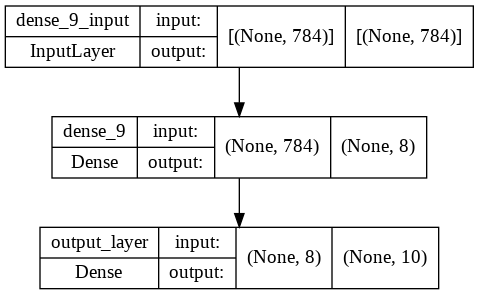

In [ ]:
keras.utils.plot_model(model7, "mnist_model.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model7.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model7.fit(
    x_train_norm # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 500 # changed from 200 to 500
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model7.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/500
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6754 - accuracy: 0.8223 - val_loss: 0.3702 - val_accuracy: 0.9158
Epoch 2/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4283 - accuracy: 0.8911 - val_loss: 0.3344 - val_accuracy: 0.9190
Epoch 3/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4015 - accuracy: 0.9007 - val_loss: 0.3085 - val_accuracy: 0.9252
Epoch 4/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3723 - accuracy: 0.9075 - val_loss: 0.2907 - val_accuracy: 0.9322
Epoch 5/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3542 - accuracy: 0.9102 - val_loss: 0.2786 - val_accuracy: 0.9348
Epoch 6/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3434 - accuracy: 0.9134 - val_loss: 0.2746 - val_accuracy: 0.9360
Epoch 7/500
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3363 - accuracy: 0.9154 - val_loss: 0.2744 - val_ac

In [ ]:
# Evaluation
model7 = tf.keras.models.load_model("DNN_model7.h5")
print(f"Test acc: {model7.evaluate(x_test_norm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 2ms/step - loss: 0.3089 - accuracy: 0.9224
Test acc: 0.922


In [ ]:
# Make Predictions
preds = model7.predict(x_test_norm) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


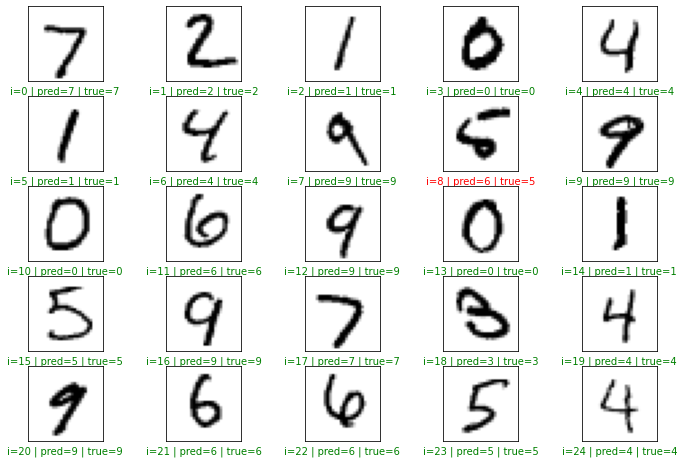

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
3  0.372     0.907     0.291         0.932
4  0.354     0.910     0.279         0.935
5  0.343     0.913     0.275         0.936
6  0.336     0.915     0.274         0.933
7  0.330     0.916     0.271         0.933

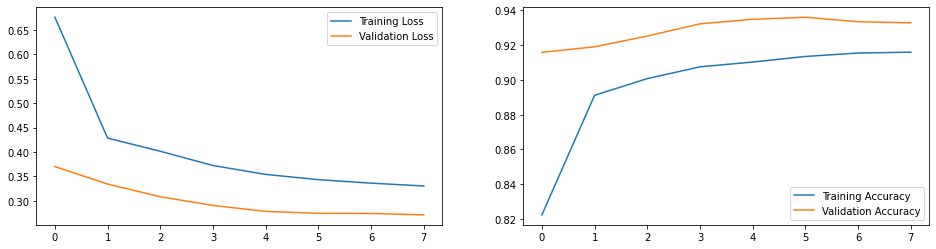

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred7= model7.predict(x_test_norm)
pred7=np.argmax(pred7, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred7)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.94      0.98      0.96      1135
           2       0.94      0.88      0.91      1032
           3       0.88      0.94      0.91      1010
           4       0.93      0.92      0.92       982
           5       0.90      0.88      0.89       892
           6       0.94      0.94      0.94       958
           7       0.93      0.90      0.92      1028
           8       0.90      0.88      0.89       974
           9       0.89      0.92      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9224
Root Mean Square Error: 1.1726892171415237


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

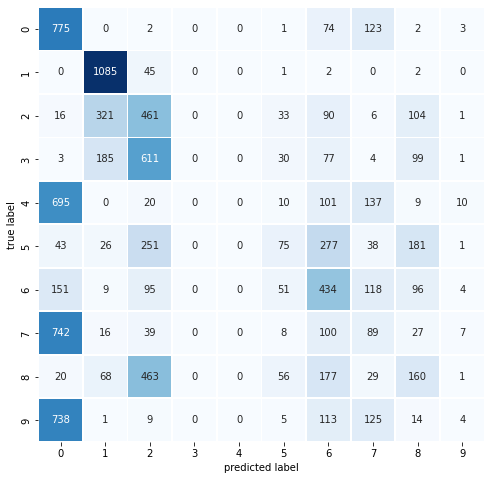

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
# cl_a, cl_b = 4, 9
# X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
# X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
# X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
# X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

# plt.figure(figsize=(16,8))

# # create subplots
# p1 = plt.subplot(221)
# p2 = plt.subplot(222)
# p3 = plt.subplot(223)
# p4 = plt.subplot(224)

# # plot the digits
# plot_digits(X_aa[:25], p1, images_per_row=5);
# plot_digits(X_ab[:25], p2, images_per_row=5);
# plot_digits(X_ba[:25], p3, images_per_row=5);
# plot_digits(X_bb[:25], p4, images_per_row=5);

# # subplot titles
# p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
# p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
# p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
# p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# # plt.savefig("error_analysis_digits_plot_EXP1_valid")

# plt.show()

The Model that performed the best was model7 with an accuracy score of .974

## Model 8

**Model 8** will be built using using 32 nodes and 200 epochs

In [ ]:
#  Create the model

model8 = Sequential([
    Dense(input_shape=[784], units=32, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # 32 nodes
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax) # hidden layer with 1 node and 10 output nodes
])



In [ ]:
model8.summary()

#shows layer type, output shape, number of parameters

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                25120     
                                                                 
 output_layer (Dense)        (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


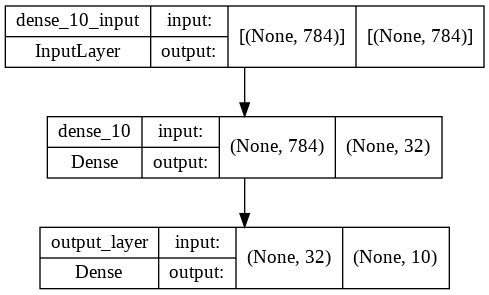

In [ ]:
keras.utils.plot_model(model8, "mnist_model.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model8.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model8.fit(
    x_train_norm # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 200 # changed from 200 to 500
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model8.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4326 - accuracy: 0.8943 - val_loss: 0.2540 - val_accuracy: 0.9470
Epoch 2/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2832 - accuracy: 0.9335 - val_loss: 0.2178 - val_accuracy: 0.9554
Epoch 3/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2472 - accuracy: 0.9431 - val_loss: 0.1998 - val_accuracy: 0.9614
Epoch 4/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2259 - accuracy: 0.9486 - val_loss: 0.1862 - val_accuracy: 0.9636
Epoch 5/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2122 - accuracy: 0.9519 - val_loss: 0.1895 - val_accuracy: 0.9608
Epoch 6/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2011 - accuracy: 0.9544 - val_loss: 0.1823 - val_accuracy: 0.9622


In [ ]:
# Evaluation
model8 = tf.keras.models.load_model("DNN_model8.h5")
print(f"Test acc: {model8.evaluate(x_test_norm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 2ms/step - loss: 0.2068 - accuracy: 0.9525
Test acc: 0.952


In [ ]:
# Make Predictions
preds = model8.predict(x_test_norm) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


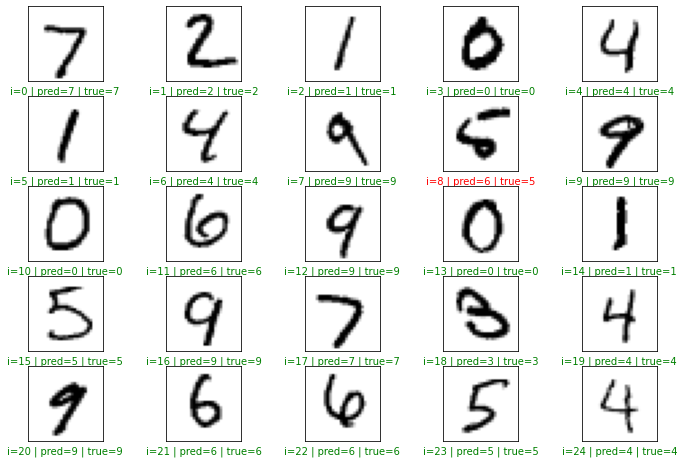

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
1  0.283     0.933     0.218         0.955
2  0.247     0.943     0.200         0.961
3  0.226     0.949     0.186         0.964
4  0.212     0.952     0.189         0.961
5  0.201     0.954     0.182         0.962

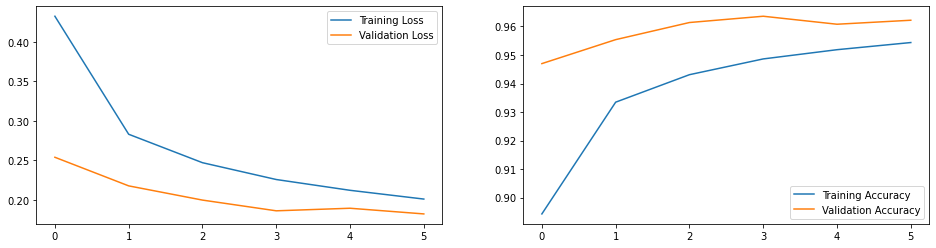

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred8= model8.predict(x_test_norm)
pred8=np.argmax(pred8, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred8)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.98      0.91      0.94      1032
           3       0.92      0.96      0.94      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.93      0.94       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.90      0.96      0.93       974
           9       0.96      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Accuracy Score: 0.9525
Root Mean Square Error: 0.9611971701997463


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model8.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

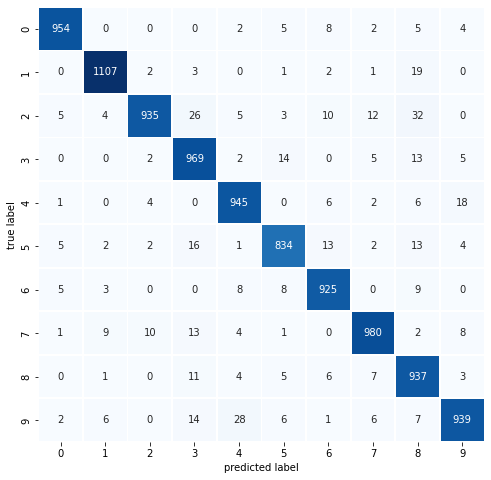

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

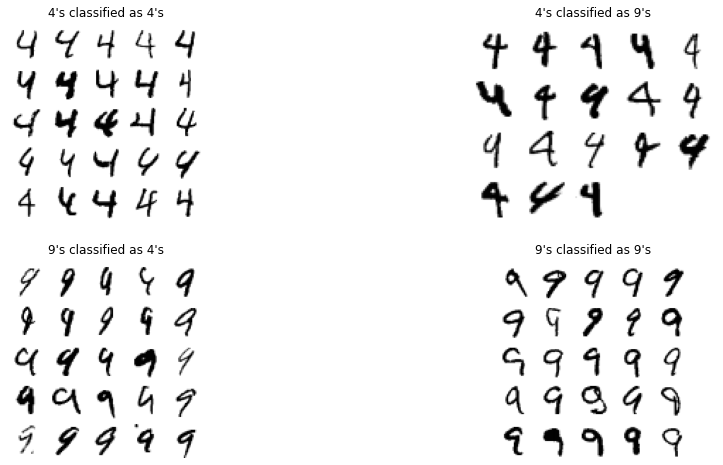

In [ ]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

plt.figure(figsize=(16,8))

# create subplots
p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

# plot the digits
plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);

# subplot titles
p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

Looking at the activation of model 8 since it scored the highest

### Analyzing the Activation Values of the Hidden Nodes

We want to examine the contribution of the individual hidden nodes to the classifications made by the model. We first get the activation values of all the hidden nodes for each of the 60,000 training images and treat these *128 activations* as the features that determine the classification class. For the sake of comparison,  we also consider the *784 pixels* of each training image and determine the contribution of the individual pixels to the predicted classification class.

Our goal is to use *box* and *scatter* plots to visualize how these features (*pixel* and *activation* values) correlate with the class labels. Because of the high dimension of the feature spaces, we apply *PCA decomposition* and *t-Distributed stochastic neighbor embedding* (`t-SNE`) to reduce the number of features in each case.

We use the following two articles as reference

 * https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
 * https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


1) Raw data is 60,000 X 784. Just do a scatter plot of col 1 vs col 2. Overlay the color coded classes. We  should not see any patterns since there is not much info in 2 cols to discriminate.

2) PCA of raw data – as we discussed earlier. Plot PC1 vs PC2 with overlay. This should be ‘better’ since these 2 capture the info from all 784 cols.

3) PCA of activation values – as we discussed earlier. This should be ‘better’ than the previous 2 since it has captured specific features of discrimination.

 ### Get the activation values of the hidden nodes

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model8.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model8.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 32)

In [ ]:
output_layer_activations.shape

(60000, 10)

In [ ]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 12.31486701965332


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.    0.    0.    0.013 0.    0.987 0.    0.    0.    0.   ]
The sum of the probabilities is (approximately) 1.0000001192092896


 ### Create a dataframe with the activation values and the class labels

In [ ]:
#Get the dataframe of all the node values
activation8_data = {'actual_class':y_train}
for k in range(0,1):
    activation8_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_8_df = pd.DataFrame(activation8_data)
activation_8_df.head(15).round(3).T

0    1     2     3      4    5      6    7      8      9    10  \
actual_class  5.0  0.0  4.00  1.00  9.000  2.0  1.000  3.0  1.000  4.000  3.0   
act_val_0     0.0  0.0  0.58  0.32  1.656  0.0  2.289  0.0  1.556  1.335  0.0   

               11   12     13     14  
actual_class  5.0  3.0  6.000  1.000  
act_val_0     0.0  0.0  1.399  1.489

 ### Visualize the activation values with boxplots

We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe.

<div class="alert alert-block alert-info">
    <b>seaborn.boxplot</b><br>
   ps://seaborn.pydata.org/generated/seaborn.boxplot.html
    </div>

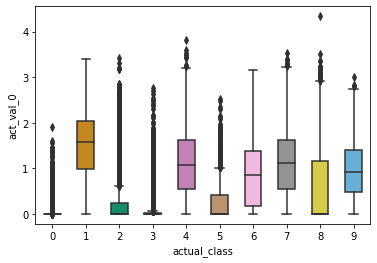

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_8_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

### Displaying The Range Of Activation Values For Each Class Labels

In [ ]:
activation_8_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

actual_class range_of_act_values
0             0          [0.0, 1.9]
1             1         [0.0, 3.39]
2             2         [0.0, 3.42]
3             3         [0.0, 2.75]
4             4         [0.0, 3.81]
5             5         [0.0, 2.52]
6             6         [0.0, 3.16]
7             7         [0.0, 3.53]
8             8         [0.0, 4.33]
9             9         [0.0, 2.99]

 ### Create a dataframe with the pixel values and class labels

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,128):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

0    1    2    3    4    5      6    7    8    9      10   11  \
actual_class  5.0  0.0  4.0  1.0  9.0  2.0  1.000  3.0  1.0  4.0  3.000  5.0   
pix_val_0     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_1     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_2     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
pix_val_3     0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
...           ...  ...  ...  ...  ...  ...    ...  ...  ...  ...    ...  ...   
pix_val_123   0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.0  0.0  0.165  0.0   
pix_val_124   0.0  0.0  0.0  0.0  0.0  0.0  0.569  0.0  0.0  0.0  0.463  0.0   
pix_val_125   0.0  0.0  0.0  0.0  0.0  0.0  1.000  0.0  0.0  0.0  0.859  0.0   
pix_val_126   0.0  0.0  0.0  0.0  0.0  0.0  0.827  0.0  0.0  0.0  0.651  0.0   
pix_val_127   0.0  0.2  0.0  0.0  0.0  0.0  0.122  0.0  0.0  0.0  0.463  0.0   

               12     13   14  
actual_class  3.0  6.000  1.0  
pix_val_0     0.0  0.000  0.0  
pix_val_1     0.0  0.000  0.0  
pix_val_2     0.0  0.000  0.0  
pix_val_3     0.0  0.000  0.0  
...           ...    ...  ...  
pix_val_123   0.0  0.000  0.0  
pix_val_124   0.0  0.000  0.0  
pix_val_125   0.0  0.090  0.0  
pix_val_126   0.0  0.773  0.0  
pix_val_127   0.0  0.992  0.0  

[129 rows x 15 columns]

# Experiment 4

EXPERIMENT 4: Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data. We then compare the performance of Experiments 3 and 4.

## PCA Feature Reduction / Model Optimization

<div class="alert alert-block alert-info">
    <b>sklearn.decomposition.PCA</b><br>
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    </div>

## Use PCA decomposition to reduce the number of features from 784 features to 154 features

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head().T

0    1    2    3    4
actual_class  5.0  0.0  4.0  1.0  9.0
pix_val_0     0.0  0.0  0.0  0.0  0.0
pix_val_1     0.0  0.0  0.0  0.0  0.0
pix_val_2     0.0  0.0  0.0  0.0  0.0
pix_val_3     0.0  0.0  0.0  0.0  0.0
...           ...  ...  ...  ...  ...
pix_val_779   0.0  0.0  0.0  0.0  0.0
pix_val_780   0.0  0.0  0.0  0.0  0.0
pix_val_781   0.0  0.0  0.0  0.0  0.0
pix_val_782   0.0  0.0  0.0  0.0  0.0
pix_val_783   0.0  0.0  0.0  0.0  0.0

[785 rows x 5 columns]

In [ ]:

# Use PCA decomposition to reduce the number of features from 784 features to 154 features for training set

# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values

pca = PCA(n_components=154)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             )
principalDf.head().round(3)

0      1      2      3      4      5      6      7      8      9    ...  \
0  0.486 -1.226 -0.096 -2.179 -0.107 -0.912  0.918  0.627 -1.426  0.778  ...   
1  3.968 -1.156  2.339 -1.807 -3.244 -0.714 -0.177 -0.412  0.159  0.592  ...   
2 -0.203  1.538 -0.739  2.043 -1.203 -0.007 -3.369  1.445 -0.449 -0.700  ...   
3 -3.134 -2.381  1.073  0.415 -0.007  2.744 -1.858 -0.264  1.187  0.044  ...   
4 -1.501  2.865  0.064 -0.948  0.385  0.170 -0.359 -1.590  0.884  0.408  ...   

     144    145    146    147    148    149    150    151    152    153  
0 -0.130  0.206  0.013 -0.054 -0.021  0.048  0.098 -0.111  0.030  0.156  
1 -0.219 -0.113 -0.195 -0.194 -0.051  0.022  0.211  0.115  0.157 -0.172  
2 -0.041  0.040 -0.100 -0.047  0.079  0.377 -0.348  0.404  0.191 -0.245  
3 -0.034 -0.063 -0.106 -0.131 -0.012  0.164  0.048  0.037 -0.008  0.021  
4  0.004 -0.052  0.028 -0.023 -0.081 -0.235  0.011  0.076 -0.116 -0.133  

[5 rows x 154 columns]

In [ ]:

# Use PCA decomposition to reduce the number of features from 784 features to 154 features for test set

#Get the dataframe of all the pixel values
pixel_data_test = {'actual_class':y_test}
for k in range(0,784):
    pixel_data_test[f"pix_val_{k}"] = x_test_norm[:,k]
pixel_df_test = pd.DataFrame(pixel_data_test)
pixel_df_test.head().T

0    1    2    3    4
actual_class  7.0  2.0  1.0  0.0  4.0
pix_val_0     0.0  0.0  0.0  0.0  0.0
pix_val_1     0.0  0.0  0.0  0.0  0.0
pix_val_2     0.0  0.0  0.0  0.0  0.0
pix_val_3     0.0  0.0  0.0  0.0  0.0
...           ...  ...  ...  ...  ...
pix_val_779   0.0  0.0  0.0  0.0  0.0
pix_val_780   0.0  0.0  0.0  0.0  0.0
pix_val_781   0.0  0.0  0.0  0.0  0.0
pix_val_782   0.0  0.0  0.0  0.0  0.0
pix_val_783   0.0  0.0  0.0  0.0  0.0

[785 rows x 5 columns]

In [ ]:
# Separating out the features
features_test = [*pixel_data_test][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df_test.loc[:, features_test].values

principalComponents_test = pca.transform(x)
principalDf_test = pd.DataFrame(data = principalComponents_test
             )
principalDf_test.round(3)

0      1      2      3      4      5      6      7      8      9    \
0    -1.303  2.933 -0.168 -1.220 -1.943  0.950  1.541  1.846 -1.566 -0.730   
1     0.081 -3.747 -0.599  1.563 -0.200 -1.845  1.095  0.907  0.577 -0.342   
2    -3.710 -1.690  0.260  1.020 -2.094  0.345 -0.094 -0.431  0.387 -0.533   
3     4.839  0.443  0.995 -0.385 -0.818 -1.904  2.728  0.299  0.084 -0.205   
4     0.742  2.802 -1.145  2.476 -0.586  0.881 -1.943  0.929 -1.338  0.763   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
9995  1.185 -2.146 -0.146  1.056  3.202  3.730  3.101  0.925 -2.219 -0.148   
9996  2.258 -2.714 -3.216 -0.753  0.461 -0.793  2.672  3.050 -0.395 -0.158   
9997 -1.060  2.341  1.393 -1.627  2.634  0.639 -0.165 -1.383 -0.097 -3.148   
9998 -1.231 -0.426  2.521 -0.994 -0.577 -1.083  0.636  0.651  1.059 -0.845   
9999  4.088 -0.355  2.769  3.317  0.734 -2.685  1.948 -1.666  0.671  0.213   

      ...    144    145    146    147    148    149    150    151    152  \
0     ... -0.028  0.050  0.158  0.269  0.153 -0.062 -0.042  0.109  0.209   
1     ... -0.186  0.021 -0.336  0.180  0.128  0.242 -0.093  0.056  0.133   
2     ... -0.013 -0.265 -0.064  0.050 -0.026  0.045  0.113  0.097 -0.059   
3     ...  0.050  0.366  0.030  0.141  0.266  0.045 -0.131  0.017 -0.014   
4     ... -0.144 -0.128  0.053  0.004 -0.101 -0.015 -0.022 -0.101 -0.102   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
9995  ... -0.109 -0.248  0.260  0.089  0.227 -0.321  0.088 -0.218 -0.016   
9996  ... -0.143 -0.235  0.256 -0.282 -0.278  0.083 -0.149  0.274  0.092   
9997  ... -0.035  0.183 -0.282  0.169  0.060 -0.329 -0.096 -0.248  0.079   
9998  ... -0.083  0.053  0.110 -0.009  0.092  0.214 -0.178 -0.072 -0.155   
9999  ... -0.172  0.477  0.141  0.003  0.278  0.051 -0.041  0.247  0.081   

        153  
0     0.257  
1    -0.031  
2    -0.053  
3     0.061  
4    -0.088  
...     ...  
9995  0.040  
9996  0.013  
9997  0.001  
9998 -0.222  
9999  0.173  

[10000 rows x 154 columns]

In [ ]:

pixel_pca_df = pd.concat([principalDf, pixel_df[['actual_class']]], axis = 1)

In [ ]:
pixel_pca_df.round(3)

0      1      2      3      4      5      6      7      8      9  \
0      0.486 -1.226 -0.096 -2.179 -0.107 -0.912  0.918  0.627 -1.426  0.778   
1      3.968 -1.156  2.339 -1.807 -3.244 -0.714 -0.177 -0.412  0.159  0.592   
2     -0.203  1.538 -0.739  2.043 -1.203 -0.007 -3.369  1.445 -0.449 -0.700   
3     -3.134 -2.381  1.073  0.415 -0.007  2.744 -1.858 -0.264  1.187  0.044   
4     -1.501  2.865  0.064 -0.948  0.385  0.170 -0.359 -1.590  0.884  0.408   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
59995 -0.391 -1.151  0.533 -1.361  1.193  0.929 -1.955 -0.932 -1.941  1.256   
59996  0.599 -2.698 -0.349 -2.549  0.778  0.725 -1.910  1.982 -2.623  0.106   
59997 -0.698  0.628 -1.010 -2.803 -0.825 -1.814 -1.822 -0.725 -0.343  1.051   
59998  0.512 -0.022  2.015  1.344 -2.044 -2.120 -0.421  0.552 -0.065 -0.368   
59999 -0.680 -0.097  2.180 -0.474 -0.776  0.914 -1.810 -0.606  0.342 -0.474   

       ...    145    146    147    148    149    150    151    152    153  \
0      ...  0.206  0.013 -0.054 -0.021  0.048  0.098 -0.111  0.030  0.156   
1      ... -0.113 -0.195 -0.194 -0.051  0.022  0.211  0.115  0.157 -0.172   
2      ...  0.040 -0.100 -0.047  0.079  0.377 -0.348  0.404  0.191 -0.245   
3      ... -0.063 -0.106 -0.131 -0.012  0.164  0.048  0.037 -0.008  0.021   
4      ... -0.052  0.028 -0.023 -0.081 -0.235  0.011  0.076 -0.116 -0.133   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
59995  ...  0.033 -0.271  0.031 -0.099 -0.058  0.168 -0.172 -0.067  0.061   
59996  ... -0.038  0.005 -0.110  0.278  0.079  0.124  0.110  0.129  0.193   
59997  ...  0.088 -0.127 -0.255  0.018  0.132 -0.256 -0.188  0.315  0.039   
59998  ...  0.187 -0.341  0.031  0.211 -0.060  0.030  0.241  0.222  0.111   
59999  ... -0.091  0.061  0.057  0.107  0.089 -0.086 -0.126  0.164 -0.171   

       actual_class  
0                 5  
1                 0  
2                 4  
3                 1  
4                 9  
...             ...  
59995             8  
59996             3  
59997             5  
59998             6  
59999             8  

[60000 rows x 155 columns]

In [ ]:
# Using model 8 ("best model")

activation_pca_df = pd.concat([principalDf, activation_8_df[['actual_class']]], axis = 1)
activation_pca_df.round(3)

0      1      2      3      4      5      6      7      8      9  \
0      0.486 -1.226 -0.096 -2.179 -0.107 -0.912  0.918  0.627 -1.426  0.778   
1      3.968 -1.156  2.339 -1.807 -3.244 -0.714 -0.177 -0.412  0.159  0.592   
2     -0.203  1.538 -0.739  2.043 -1.203 -0.007 -3.369  1.445 -0.449 -0.700   
3     -3.134 -2.381  1.073  0.415 -0.007  2.744 -1.858 -0.264  1.187  0.044   
4     -1.501  2.865  0.064 -0.948  0.385  0.170 -0.359 -1.590  0.884  0.408   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
59995 -0.391 -1.151  0.533 -1.361  1.193  0.929 -1.955 -0.932 -1.941  1.256   
59996  0.599 -2.698 -0.349 -2.549  0.778  0.725 -1.910  1.982 -2.623  0.106   
59997 -0.698  0.628 -1.010 -2.803 -0.825 -1.814 -1.822 -0.725 -0.343  1.051   
59998  0.512 -0.022  2.015  1.344 -2.044 -2.120 -0.421  0.552 -0.065 -0.368   
59999 -0.680 -0.097  2.180 -0.474 -0.776  0.914 -1.810 -0.606  0.342 -0.474   

       ...    145    146    147    148    149    150    151    152    153  \
0      ...  0.206  0.013 -0.054 -0.021  0.048  0.098 -0.111  0.030  0.156   
1      ... -0.113 -0.195 -0.194 -0.051  0.022  0.211  0.115  0.157 -0.172   
2      ...  0.040 -0.100 -0.047  0.079  0.377 -0.348  0.404  0.191 -0.245   
3      ... -0.063 -0.106 -0.131 -0.012  0.164  0.048  0.037 -0.008  0.021   
4      ... -0.052  0.028 -0.023 -0.081 -0.235  0.011  0.076 -0.116 -0.133   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
59995  ...  0.033 -0.271  0.031 -0.099 -0.058  0.168 -0.172 -0.067  0.061   
59996  ... -0.038  0.005 -0.110  0.278  0.079  0.124  0.110  0.129  0.193   
59997  ...  0.088 -0.127 -0.255  0.018  0.132 -0.256 -0.188  0.315  0.039   
59998  ...  0.187 -0.341  0.031  0.211 -0.060  0.030  0.241  0.222  0.111   
59999  ... -0.091  0.061  0.057  0.107  0.089 -0.086 -0.126  0.164 -0.171   

       actual_class  
0                 5  
1                 0  
2                 4  
3                 1  
4                 9  
...             ...  
59995             8  
59996             3  
59997             5  
59998             6  
59999             8  

[60000 rows x 155 columns]

## Use a scatter plot to visualize the predictive power of the two principal component values.

Using seaborn this time...

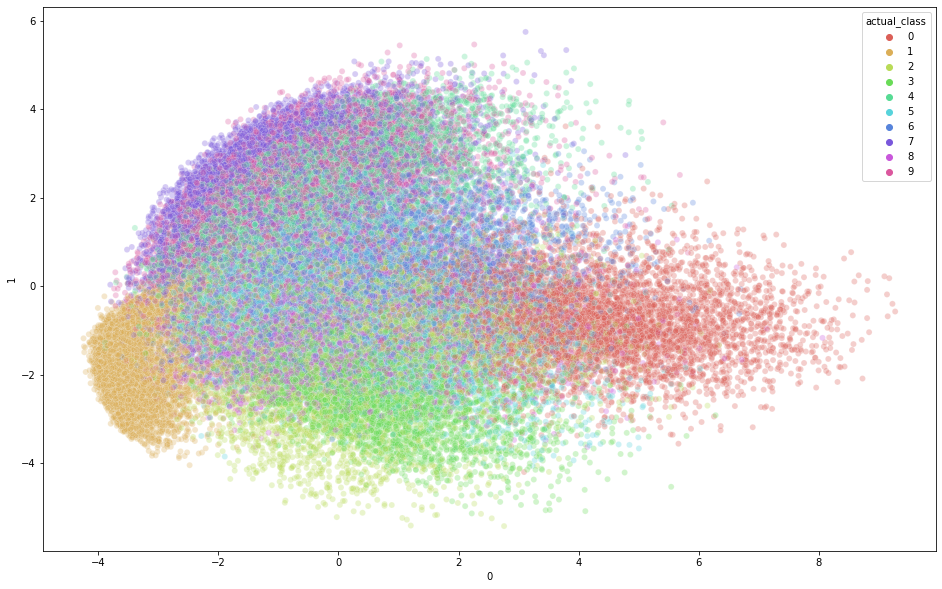

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=1,
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=pixel_pca_df,
    legend="full",
    alpha=0.3
);

Using the best model. THe previous best model of models 1-8 was model 8. Model 8 has 32 nodes in the hidden layer, 200 epochs, and an activation layer of softmax for the hidden layer

In [ ]:
model9 = Sequential([
    Dense(input_shape=[154], units=32, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

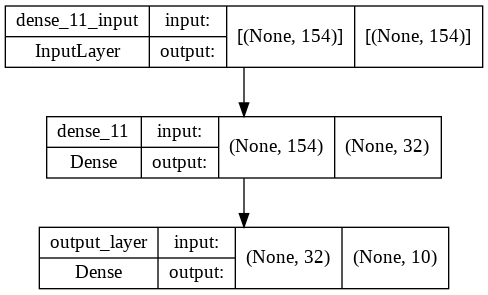

In [ ]:
keras.utils.plot_model(model9, "mnist_model9.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model9.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
x_train_norm.shape

(60000, 784)

In [ ]:
y_train_encoded.shape

(60000, 10)

In [ ]:
principalDf.shape

(60000, 154)

In [ ]:
x_test_norm.shape

(10000, 784)

In [ ]:
principalDf.shape

(60000, 154)

In [ ]:
# Fit the model
history = model9.fit(
    principalDf # using normalzied x_train
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 200 # changed from 200 to 500
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model9.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5032 - accuracy: 0.8586 - val_loss: 0.1838 - val_accuracy: 0.9498
Epoch 2/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2033 - accuracy: 0.9411 - val_loss: 0.1441 - val_accuracy: 0.9630
Epoch 3/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1604 - accuracy: 0.9523 - val_loss: 0.1261 - val_accuracy: 0.9658
Epoch 4/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1359 - accuracy: 0.9605 - val_loss: 0.1198 - val_accuracy: 0.9700
Epoch 5/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1205 - accuracy: 0.9654 - val_loss: 0.1133 - val_accuracy: 0.9708
Epoch 6/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1092 - accuracy: 0.9687 - val_loss: 0.1119 - val_accuracy: 0.9718
Epoch 7/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1007 - accuracy: 0.9711 - val_loss: 0.1089 - val_ac

In [ ]:
# Evaluation
model9 = tf.keras.models.load_model("DNN_model9.h5")
print(f"Test acc: {model9.evaluate(principalDf_test, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 1ms/step - loss: 0.1232 - accuracy: 0.9656
Test acc: 0.966


In [ ]:
# Make Predictions
preds = model9.predict(principalDf_test) # make predictions or Y_Test, using X_test
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


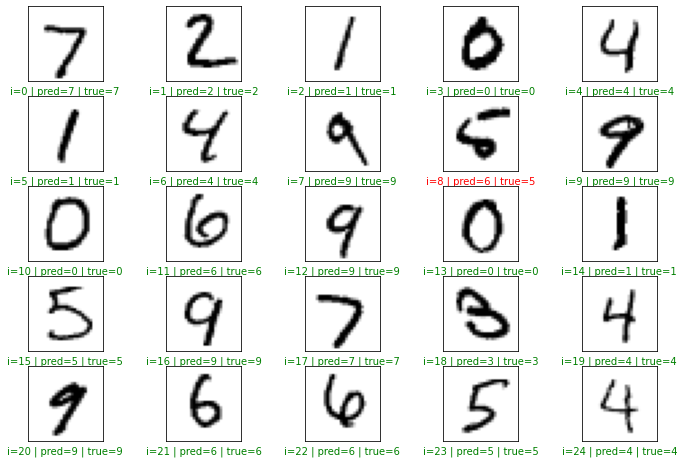

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
3  0.136     0.961     0.120         0.970
4  0.121     0.965     0.113         0.971
5  0.109     0.969     0.112         0.972
6  0.101     0.971     0.109         0.970
7  0.095     0.973     0.110         0.970

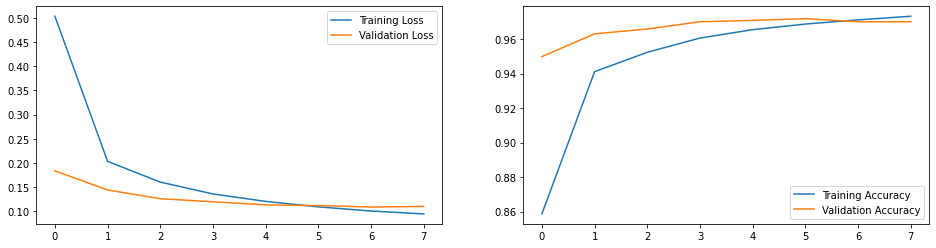

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred9= model9.predict(principalDf_test)
pred9=np.argmax(pred9, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred9)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.96      0.96       892
           6       0.96      0.97      0.97       958
           7       0.96      0.97      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9656
Root Mean Square Error: 0.8421995013059554


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model9.predict(principalDf_test), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

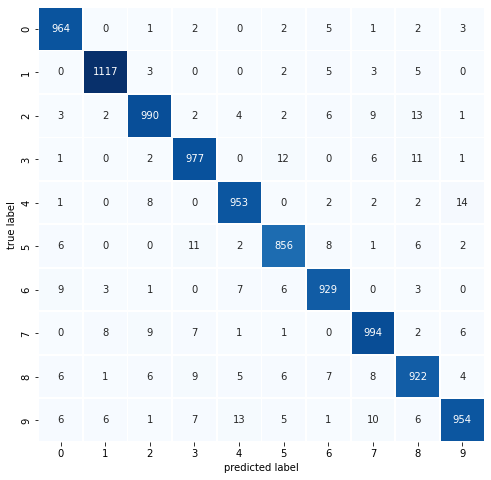

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

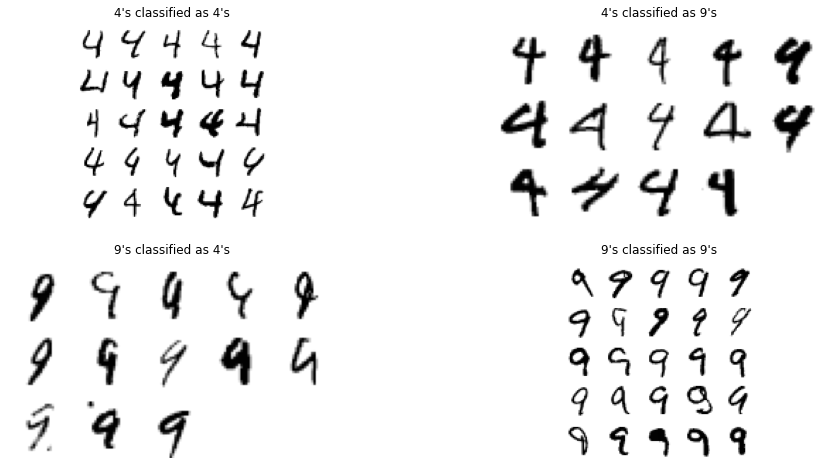

In [ ]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

plt.figure(figsize=(16,8))

# create subplots
p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

# plot the digits
plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);

# subplot titles
p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

# Experiment 5

## Reducing dimensionality of the data with Random Forests.

We create a Random Forest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features (using code from Hands On Machine Learning by A. Geron). Finally, we select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

<div class="alert alert-block alert-info">
    <b>sklearn.ensemble.RandomForestClassifier</b><br>
  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    </div>

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=70, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(n_estimators=70, random_state=42)

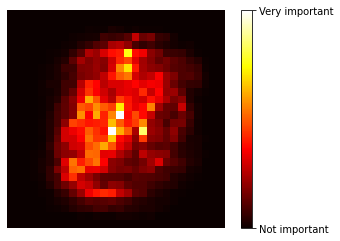

In [ ]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [ ]:
# # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70 # set the number of important features
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

## Create Training and Test Examples Leveraging 70 Pixels

In [ ]:
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

((60000, 70), (10000, 70))

## Visualize the 70 pixels
We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. These are the features (pixels) we train our neural network on.

In [ ]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size
    y = n%size
    return x,y

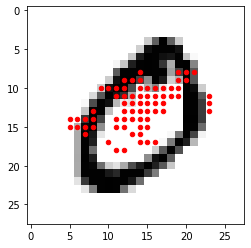

In [ ]:
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

Now using the best of the models

In [ ]:
model_rf = Sequential([
    Dense(input_shape=[70], units=32, activation = tf.nn.relu), # using 70 input layers, 32 nodes because that is what the best model had
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model_rf.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                2272      
                                                                 
 output_layer (Dense)        (None, 10)                330       
                                                                 
Total params: 2,602
Trainable params: 2,602
Non-trainable params: 0
_________________________________________________________________


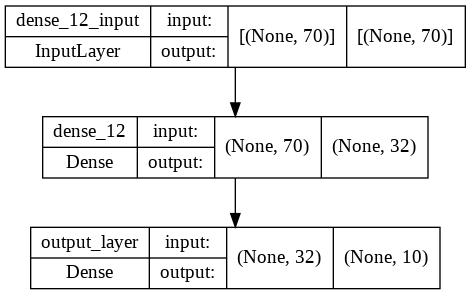

In [ ]:
keras.utils.plot_model(model_rf, "mnist_model10.png", show_shapes=True) # keras.utils.plot_model() prints the graphic of the model

In [ ]:
# Compile the model
model_rf.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Fit the model
history = model_rf.fit(
    train_images_sm  #
    ,y_train_encoded # using one hot encoded y_train
    ,epochs = 200
    ,validation_split=0.0833 # 5,000 of the 60,000 held back for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model10.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7210 - accuracy: 0.7883 - val_loss: 0.4291 - val_accuracy: 0.8707
Epoch 2/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4931 - accuracy: 0.8525 - val_loss: 0.3745 - val_accuracy: 0.8876
Epoch 3/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4401 - accuracy: 0.8675 - val_loss: 0.3456 - val_accuracy: 0.8982
Epoch 4/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4080 - accuracy: 0.8773 - val_loss: 0.3248 - val_accuracy: 0.9016
Epoch 5/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3846 - accuracy: 0.8841 - val_loss: 0.3051 - val_accuracy: 0.9088
Epoch 6/200
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3662 - accuracy: 0.8897 - val_loss: 0.2920 - val_accuracy: 0.9154
Epoch 7/200
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3517 - accuracy: 0.8953 - val_loss: 0.2799 - val_ac

In [ ]:
# Evaluation
model_rf = tf.keras.models.load_model("DNN_model10.h5")
print(f"Test acc: {model_rf.evaluate(test_images_sm, y_test_encoded)[1]:.3f}") # elevaluate shows loss and accuracy scores for the model

313/313 [==============================] - 1s 1ms/step - loss: 0.2910 - accuracy: 0.9113
Test acc: 0.911


In [ ]:
# Make Predictions
preds = model_rf.predict(train_images_sm)
print('shape of preds: ', preds.shape)

shape of preds:  (60000, 10)


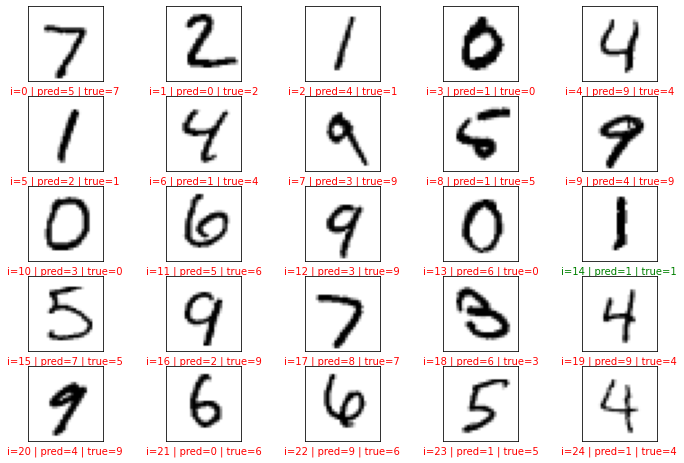

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred != actual:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

### Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys() # shows the elements of history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict) # making history a dataframe
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
11  0.306     0.909     0.250         0.931
12  0.300     0.911     0.244         0.930
13  0.296     0.912     0.239         0.933
14  0.291     0.913     0.244         0.929
15  0.289     0.914     0.235         0.933

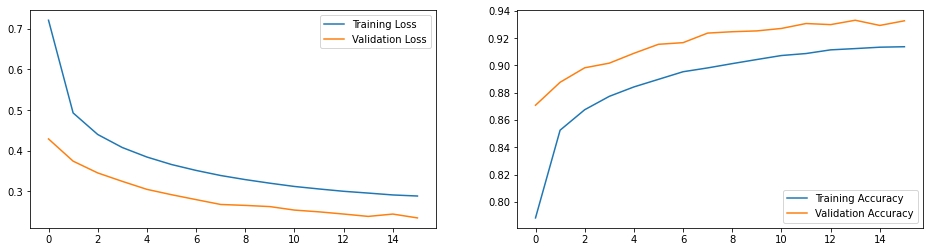

In [ ]:
# Line plots of Loss and accuracy for training and validation
plot_history(history)

In [ ]:
pred_rf= model_rf.predict(test_images_sm)
pred_rf=np.argmax(pred_rf, axis=1)

In [ ]:
# show classifcation report for the predictions
print_validation_report(y_test, pred6)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       980
           1       0.90      0.96      0.93      1135
           2       0.89      0.84      0.87      1032
           3       0.84      0.84      0.84      1010
           4       0.87      0.87      0.87       982
           5       0.78      0.71      0.75       892
           6       0.89      0.91      0.90       958
           7       0.86      0.83      0.84      1028
           8       0.78      0.74      0.76       974
           9       0.83      0.86      0.84      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy Score: 0.853
Root Mean Square Error: 1.5


### Confusion Matrix

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model_rf.predict(test_images_sm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

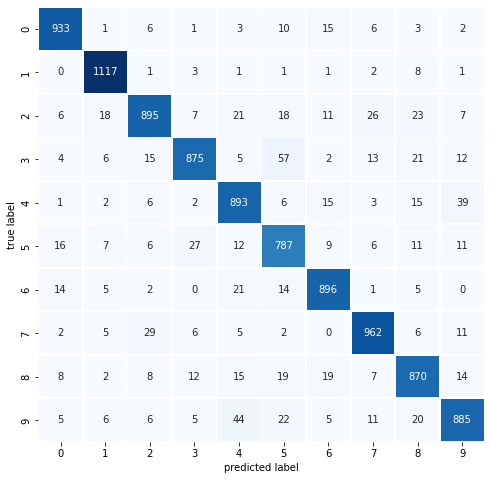

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

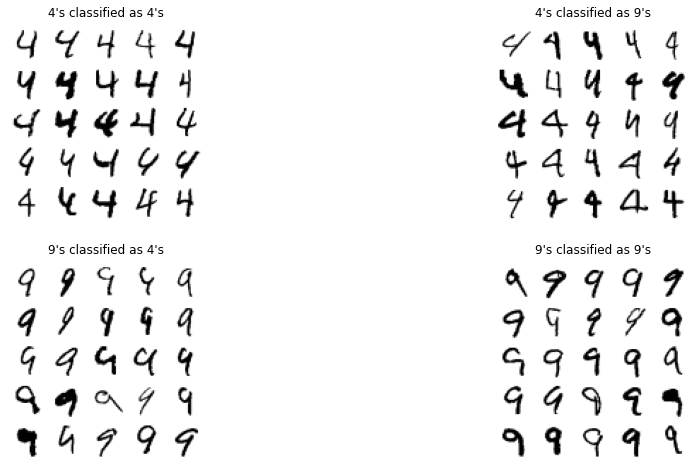

In [ ]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)] # 4 actual, 4 predicted
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)] # 4 actual, 9 predicted
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)] # 9 actual, 4 predicted
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)] # 9 actual, 9 predicted

plt.figure(figsize=(16,8))

# create subplots
p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

# plot the digits
plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);

# subplot titles
p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()